In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install and Import Packages**

In [ ]:

!pip install pandas numpy nltk tensorflow matplotlib rouge-score pycocoevalcap

import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

tf.config.run_functions_eagerly(True)
print("Eager execution enabled:", tf.executing_eagerly())
tf.data.experimental.enable_debug_mode()
nltk.download('punkt')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 9.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=3e5d24ccf87bacbbee08c724e82c2745abe96a557478084b6cf2af3b644ead07
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
Eager execution enabled: True


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **Data Preparation**

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/DL_Dataset/questions.csv').dropna().head(35000)
df[['question1', 'question2', 'is_duplicate']].dropna()
df = df[df['is_duplicate'] == 1]  # Use only duplicate (paraphrase) pairs
print(f"Dataset size: {len(df)} rows")
questions1 = df['question1'].astype(str).tolist()
questions2 = df['question2'].astype(str).tolist()

questions2_with_tokens = ['<start> ' + q + ' <end>' for q in questions2]

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(questions1 + questions2_with_tokens)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

start_token_idx = tokenizer.word_index.get('<start>', 0)
end_token_idx = tokenizer.word_index.get('<end>', 0)
print(f"<start> token index: {start_token_idx}")
print(f"<end> token index: {end_token_idx}")

index_word = {v: k for k, v in tokenizer.word_index.items()}

max_len = 10  # change it if required
encoder_input = pad_sequences(tokenizer.texts_to_sequences(questions1), maxlen=max_len, padding='post')

decoder_input_raw = []
decoder_target_raw = []
for q in questions2_with_tokens:
    words = q.split()
    decoder_input_raw.append(' '.join(words[:-1]))
    decoder_target_raw.append(' '.join(words[1:]))

decoder_input = pad_sequences(tokenizer.texts_to_sequences(decoder_input_raw), maxlen=max_len, padding='post')
decoder_target = pad_sequences(tokenizer.texts_to_sequences(decoder_target_raw), maxlen=max_len, padding='post')

print("Encoder input shape:", encoder_input.shape)
print("Decoder input shape:", decoder_input.shape)
print("Decoder target shape:", decoder_target.shape)

Dataset size: 13039 rows
Vocabulary size: 11373
<start> token index: 0
<end> token index: 0
Encoder input shape: (13039, 10)
Decoder input shape: (13039, 10)
Decoder target shape: (13039, 10)


# **Luong Attention**

In [ ]:

def build_basic_seq2seq(vocab_size, max_len, embedding_dim=256, latent_dim=512):
    encoder_inputs = tf.keras.layers.Input(shape=(max_len,))
    encoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)(encoder_inputs)
    encoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3)
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    decoder_inputs = tf.keras.layers.Input(shape=(max_len,))
    decoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)(decoder_inputs)
    decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.3)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    attention_layer = tf.keras.layers.Attention()
    context_vector = attention_layer([decoder_outputs, encoder_outputs])
    concat = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs, context_vector])
    decoder_dense = tf.keras.layers.Dense(vocab_size, activation='softmax')
    final_outputs = decoder_dense(concat)

    model = tf.keras.Model([encoder_inputs, decoder_inputs], final_outputs)

    encoder_model = tf.keras.Model(encoder_inputs, [encoder_outputs, state_h, state_c])

    decoder_state_input_h = tf.keras.layers.Input(shape=(latent_dim,))
    decoder_state_input_c = tf.keras.layers.Input(shape=(latent_dim,))
    encoder_outputs_input = tf.keras.layers.Input(shape=(max_len, latent_dim))
    dec_emb2 = decoder_embedding
    decoder_outputs2, state_h2, state_c2 = decoder_lstm(
        dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
    context_vector2 = attention_layer([decoder_outputs2, encoder_outputs_input])
    concat2 = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs2, context_vector2])
    decoder_outputs2 = decoder_dense(concat2)
    decoder_model = tf.keras.Model(
        [decoder_inputs, decoder_state_input_h, decoder_state_input_c, encoder_outputs_input],
        [decoder_outputs2, state_h2, state_c2, context_vector2]
    )

    return model, encoder_model, decoder_model

model, encoder_model, decoder_model = build_basic_seq2seq(vocab_size, max_len)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 256)   │  2,911,488 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 256)   │  2,911,488 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 10, 512), │  1,574,912 │ embedding[0][0]   │
│                     │ (None, 512),      │            │                   │
│                     │ (None, 512)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 10, 512), │  1,574,912 │ embedding_1[0][0… │
│                     │ (None, 512),      │            │ lstm[0][1],       │
│                     │ (None, 512)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 10, 512)   │          0 │ lstm_1[0][0],     │
│ (Attention)         │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 1024)  │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 11373) │ 11,657,325 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 20,630,125 (78.70 MB)

 Trainable params: 20,630,125 (78.70 MB)

 Non-trainable params: 0 (0.00 B)

# **Training**

Starting training...
Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 44s 202ms/step - accuracy: 0.2014 - loss: 6.1538
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - accuracy: 0.3282 - loss: 4.4766
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - accuracy: 0.3737 - loss: 3.9588
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - accuracy: 0.4180 - loss: 3.4669
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 41s 201ms/step - accuracy: 0.4549 - loss: 3.0178
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - accuracy: 0.4945 - loss: 2.6110
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - accuracy: 0.5363 - loss: 2.2537
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - accuracy: 0.5891 - loss: 1.9287
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - accuracy: 0.6335 - loss: 1.6556
Epoch 10/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 40s 196ms/step - accuracy: 0.6785 - loss: 1.4251
Training Time: 405.31 seconds


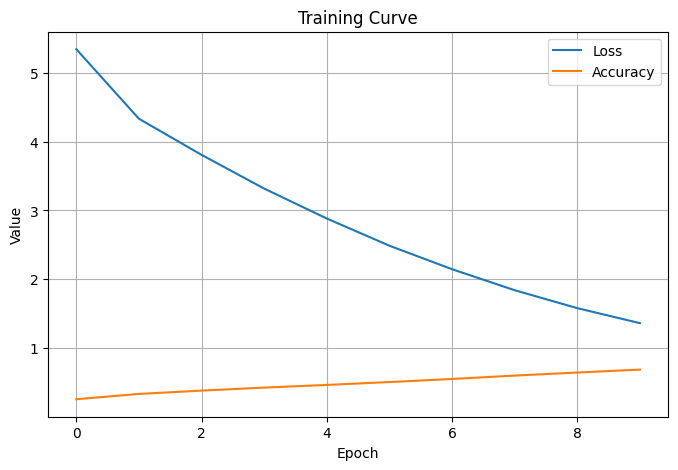

Model saved to seq2seq_model_with_attention.h5


In [ ]:

batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices(
    ((encoder_input, decoder_input), np.expand_dims(decoder_target, -1))
).batch(batch_size).prefetch(tf.data.AUTOTUNE)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=4,
    restore_best_weights=True
)

print("Starting training...")
start_train = time.time()
history = model.fit(
    train_dataset,
    epochs=10,
    callbacks=[early_stopping]
)
end_train = time.time()
print(f"Training Time: {end_train - start_train:.2f} seconds")

def plot_training_curve(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Loss')
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.title('Training Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curve(history)
model.save('seq2seq_model_with_attention.h5')
print("Model saved to seq2seq_model_with_attention.h5")

# **Inference & Attention Map Visualization**


Generating example predictions:
-
Input: What the purpose of life on earth?
Actual: Why is the purpose of life to "be happy?"
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted: samajwadi incest allows invaders decade cleared aircraft handsets upset
-
Input: What was the best sexual experience you've ever had?
Actual: What's the best sex you have ever had?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/st

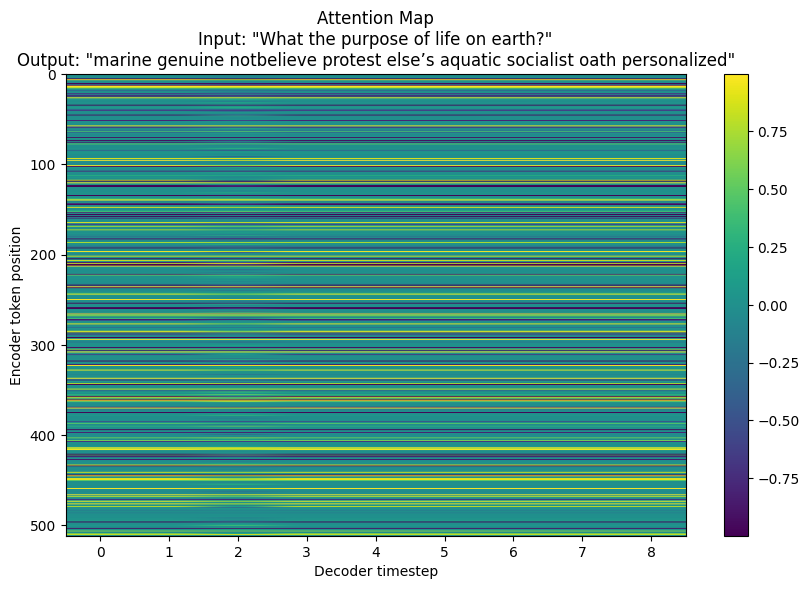

In [ ]:

def generate_response(input_text, max_length=max_len, temperature=0.7, return_attention=False):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')
    encoder_outputs, state_h, state_c = encoder_model.predict(input_seq)
    states_value = [state_h, state_c]
    target_seq = np.zeros((1, max_len))
    target_seq[0, 0] = start_token_idx
    decoded_sentence = ""
    attentions = []
    for i in range(1, max_length):
        output_tokens, h, c, attention_weights = decoder_model.predict(
            [target_seq, states_value[0], states_value[1], encoder_outputs]
        )
        predictions = output_tokens[0, i-1]
        predictions = np.exp(predictions / temperature)
        predictions = predictions / np.sum(predictions)
        sampled_token_index = np.random.choice(len(predictions), p=predictions)
        sampled_word = index_word.get(sampled_token_index, "")
        if sampled_token_index == end_token_idx or len(decoded_sentence.split()) >= max_length-1:
            break
        if sampled_word:
            decoded_sentence += sampled_word + " "
        target_seq[0, i] = sampled_token_index
        states_value = [h, c]
        if return_attention:
            attentions.append(attention_weights[0, i-1, :])
    if return_attention:
        return decoded_sentence.strip(), np.array(attentions)
    return decoded_sentence.strip()

print("\nGenerating example predictions:")
test_indices = np.random.randint(0, len(questions1), 3)
for i in test_indices:
    print('-')
    print('Input:', questions1[i])
    print('Actual:', questions2[i])
    print('Predicted:', generate_response(questions1[i]))

def plot_attention_map(input_sentence):
    decoded, attentions = generate_response(input_sentence, return_attention=True)
    plt.figure(figsize=(10, 6))
    plt.imshow(attentions.T, aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.xlabel('Decoder timestep')
    plt.ylabel('Encoder token position')
    plt.title(f'Attention Map\nInput: \"{input_sentence}\"\nOutput: \"{decoded}\"')
    plt.show()

plot_attention_map(questions1[test_indices[0]])

# **Evaluation**

In [ ]:

nltk.download('punkt_tab')
nltk.download('wordnet')
refs = []
hyps = []
for i in range(min(10, len(questions1))):
    q1 = questions1[i]
    q2 = questions2[i]
    hyp = generate_response(q1)
    refs.append([q2])
    hyps.append(hyp)
    print(f"\nQ1: {q1}")
    print(f"Original Q2: {q2}")
    print(f"Generated  : {hyp}")

bleu_scores = [
    sentence_bleu([word_tokenize(ref[0].lower())], word_tokenize(hyp.lower()))
    for ref, hyp in zip(refs, hyps)
]
print(f"\nAverage BLEU: {np.mean(bleu_scores):.4f}")

rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(ref[0], hyp) for ref, hyp in zip(refs, hyps)]
avg_rouge1 = np.mean([s['rouge1'].fmeasure for s in rouge_scores])
print(f"Average ROUGE-1 F1: {avg_rouge1:.4f}")

meteor_scores = [
    meteor_score([word_tokenize(ref[0].lower())], word_tokenize(hyp.lower()))
    for ref, hyp in zip(refs, hyps)
]
print(f"Average METEOR: {np.mean(meteor_scores):.4f}")

start_infer = time.time()
_ = generate_response("What is your name?")
end_infer = time.time()
print(f"\nInference Time: {end_infer - start_infer:.4f} seconds")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Q1: Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
Original Q2: I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?
Generated  : afford oppression marine ripple pennsylvania dangling homesickness worlds before
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0